## Importations

In [18]:
import tensorflow
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import numpy as np

import matplotlib.pyplot as plt
import PIL.Image

from glob import glob
import itertools
import os

import opendatasets


## Importing dataset through kaggle

In [19]:
opendatasets.download("https://www.kaggle.com/datasets/paultimothymooney/blood-cells/")

Skipping, found downloaded files in ".\blood-cells" (use force=True to force download)


In [20]:
# Paths
directory = 'blood-cells\dataset2-master\dataset2-master\images'

train_path = os.path.join(directory, "TRAIN")
valid_path = os.path.join(directory, "TEST")

# Files
train_image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')
folders = glob(train_path + '/*')   # ie number of classes 

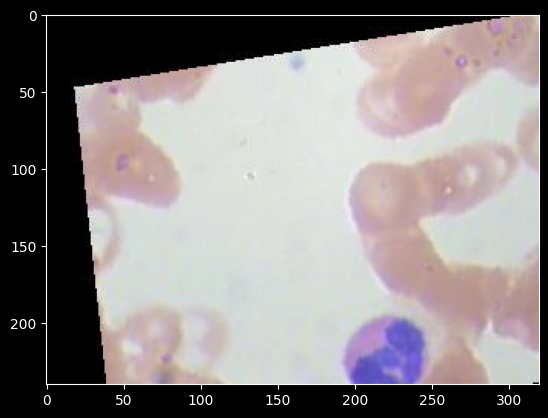

In [21]:
random_image = tensorflow.keras.preprocessing.image.load_img(np.random.choice(train_image_files))
plt.imshow(random_image)
plt.show()

In [22]:
# Configuration

IMAGE_SIZE  = list(random_image.size)
EPOCHS      = 16
BATCH_SIZE  = 32

### VGG

In [23]:
# Importing the VGG weights from imagenet; Transfer learning => include_top = false
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# Setting all the layers as not trainable
for layer in vgg.layers:
    layer.trainable = False
    
# Classifier layers
x = Flatten()(vgg.output)
prediction = Dense(len(folders), activation='softmax')(x)

# Model instance
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()
model.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 320, 240, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 320, 240, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 320, 240, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 160, 120, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 160, 120, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 160, 120, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 80, 60, 128)       0   

In [24]:
# Instance of Image Data Generator
generator = ImageDataGenerator(
    rotation_range=20, 
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

In [25]:
# Train and validation generators
from random import shuffle


train_generator = generator.flow_from_directory(
    train_path, 
    target_size=IMAGE_SIZE, 
    shuffle=True, 
    batch_size=BATCH_SIZE
)

valid_generator = generator.flow_from_directory(
    valid_path, 
    target_size=IMAGE_SIZE, 
    shuffle=True, 
    batch_size=BATCH_SIZE
)

Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


In [26]:
# Train the model

r = model.fit(
    train_generator, 
    validation_data=valid_generator, 
    epochs=EPOCHS, 
    steps_per_epoch=len(train_image_files) // BATCH_SIZE, 
    validation_steps = len(valid_image_files) // BATCH_SIZE
)

Epoch 1/16
311/311 [==============================] - 496s 2s/step - loss: 20.4861 - accuracy: 0.4898 - val_loss: 31.7862 - val_accuracy: 0.3413
Epoch 2/16
311/311 [==============================] - 489s 2s/step - loss: 12.5492 - accuracy: 0.6457 - val_loss: 20.1996 - val_accuracy: 0.4858
Epoch 3/16
311/311 [==============================] - ETA: 0s - loss: 10.6203 - accuracy: 0.6987

KeyboardInterrupt: 

In [ ]:
# outputing the confusion matrix

def get_confusion_matrix(data_path, N):
    predictions = []
    targets     = []
    # from generators to numpy array
    for x, y in generator.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=BATCH_SIZE):
        p = model.predict(x)
        p = np.argmax(p, axis=1)
        y = np.argmax(y, axis=1)
        predictions = np.concatenate((predictions, p))
        targets     = np.concatenate((targets, y))
        if len(targets) >= N:
            break
        
    matrix = confusion_matrix(targets, predictions)
    return matrix


confusion_train = get_confusion_matrix(train_path, len(train_image_files))
print(confusion_train)

In [ ]:
confusion_valid = get_confusion_matrix(valid_path, len(valid_image_files))
print(confusion_valid)


In [ ]:
# plotting loss
plt.plot(r.history['loss'], label='training loss')
plt.plot(r.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

In [ ]:
# plotting acc
plt.plot(r.history['acc'], label='training accuracy')
plt.plot(r.history['val_acc'], label='validation accuracy')
plt.legend()
plt.show()